In [84]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [85]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, connect, sparse_connect

In [86]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [87]:
# load data from grads notebook! 
def load_dataset(path="/n/home12/isanchez/jaxneuro/outputs/local_phys_dataset.npz"):
    d = np.load(path)
    out = {k: d[k] for k in d.files}
    for k in ("dt", "t_max", "i_delay", "i_dur", "N_trials", "Nsyn"):
        if k in out:
            out[k] = float(out[k]) if "." in str(out[k]) else int(out[k])
    return out

ds = load_dataset()

GRADS = ds["GRADS"]  # (N, Nsyn)
VLOCAL = ds["VLOCAL"]  # (N, Nsyn -1, T)
VSOMA = ds["VSOMA"]   # (N, T)
VALL = ds["VALL"]  # (N, Nsyn, T)
patterns = ds["patterns"] # (N, Nsyn)
losses = ds["losses"]  # (N,)
syn_post_comp_indices = ds["syn_post_comp_indices"]

dt = ds["dt"]
t_max = ds["t_max"]
i_delay = ds["i_delay"]
i_dur = ds["i_dur"]

N, Nsyn = GRADS.shape
T = VALL.shape[2]

# time axis
t = np.arange(T) * dt  # (T,)

# stimulus boolean mask
t_stim = (t >= i_delay) & (t <= i_delay + i_dur)


print(f"GRADS: {GRADS.shape}")
print(f"VLOCAL: {VLOCAL.shape}")
print(f"VSOMA: {VSOMA.shape}")
print(f"VALL: {VALL.shape}")
print(f"patterns:{patterns.shape}")
print(f"losses: {losses.shape}")
print(f"\n dt={dt} ms, t_max={t_max} ms,T={T} timepoints")
print(f"i_delay={i_delay} ms,i_dur={i_dur} ms")
print(f"stimulus window: {t_stim.sum()} timepoints "
      f"({t[t_stim][0]:.3f}–{t[t_stim][-1]:.3f} ms)")
print(f" N_trials={N},  Nsyn={Nsyn}")
print(f"syn_post_comp_indices = {syn_post_comp_indices}")

assert GRADS.shape == (N, Nsyn)
assert VLOCAL.shape == (N, Nsyn -1, T)
assert VSOMA.shape  == (N, T)
assert VALL.shape == (N, Nsyn, T)
print("\nAll shape checks passed!!!")


GRADS: (500, 8)
VLOCAL: (500, 7, 2002)
VSOMA: (500, 2002)
VALL: (500, 8, 2002)
patterns:(500, 8)
losses: (500,)

 dt=0.025 ms, t_max=50.0 ms,T=2002 timepoints
i_delay=3.0 ms,i_dur=2.0 ms
stimulus window: 81 timepoints (3.000–5.000 ms)
 N_trials=500,  Nsyn=8
syn_post_comp_indices = [ 0  2  4  6  8 10 12 14]

All shape checks passed!!!


## Step 7a: time correlation map

At each timepoint t and for each synapse, we can compute the Pearson correlation (across trials n) between a local signal $x_{n,i}(t)$ and the scalar gradient $g_{n,i}$ so that we have 

$$r_i(t) = \text{corr}_n\!\big(x_{n,i}(t),\; g_{n,i}\big)$$

and then aggregate $\overline{r^2}(t) = \text{mean}_i\, r_i(t)^2$


Becuase I have v_soma and v_local, I can compute the correlation with the gradient of v_local. And separetly do v_soma? Or does it make more sense to do all at once? 

In [88]:
def time_resolved_corr(signal, grads):
    N, Nsyn, T = signal.shape
    assert grads.shape == (N, Nsyn), f"Expected grads {(N, Nsyn)}, got {grads.shape}"

    r_by_syn = np.zeros((Nsyn, T))
    for i in range(Nsyn):
        g_i = grads[:, i] # in R^N
        # vectorised pearson r across all timepoints at once
        # signal[:, i, :] is (N, T) — correlate each column with g_i
        x = signal[:, i, :]  # in R^N
        # demean
        x_dm = x - x.mean(axis=0, keepdims=True)
        g_dm = g_i - g_i.mean()
        num = (x_dm * g_dm[:, None]).sum(axis=0)          # (T,)
        denom = np.sqrt((x_dm**2).sum(axis=0) * (g_dm**2).sum()) + 1e-30 # want to prevent division by zero 
        r_by_syn[i] = num / denom # (Nsyn, T)
    return r_by_syn


r_v_all = time_resolved_corr(VALL, GRADS) # (Nsyn, T)
mean_r2_v_all = (r_v_all**2).mean(axis=0)  # (T,)
mean_r_v_all = r_v_all.mean(axis=0) # (T,)


## look at changes in voltage? 
dVdt = np.gradient(VALL, dt, axis=2)  # (N, Nsyn, T)
r_dvdt = time_resolved_corr(dVdt, GRADS)  # (Nsyn, T)
mean_r2_dvdt = (r_dvdt**2).mean(axis=0) # (T,)
mean_r_dvdt = r_dvdt.mean(axis=0) # (T,)

print(f"r_v_all shape: {r_v_all.shape}")
print(f"mean_r2_v_all shape: {mean_r2_v_all.shape}")
print(f"r_dvdt shape: {r_dvdt.shape}")
print(f"mean_r2_dvdt shape: {mean_r2_dvdt.shape}")


r_v_all shape: (8, 2002)
mean_r2_v_all shape: (2002,)
r_dvdt shape: (8, 2002)
mean_r2_dvdt shape: (2002,)


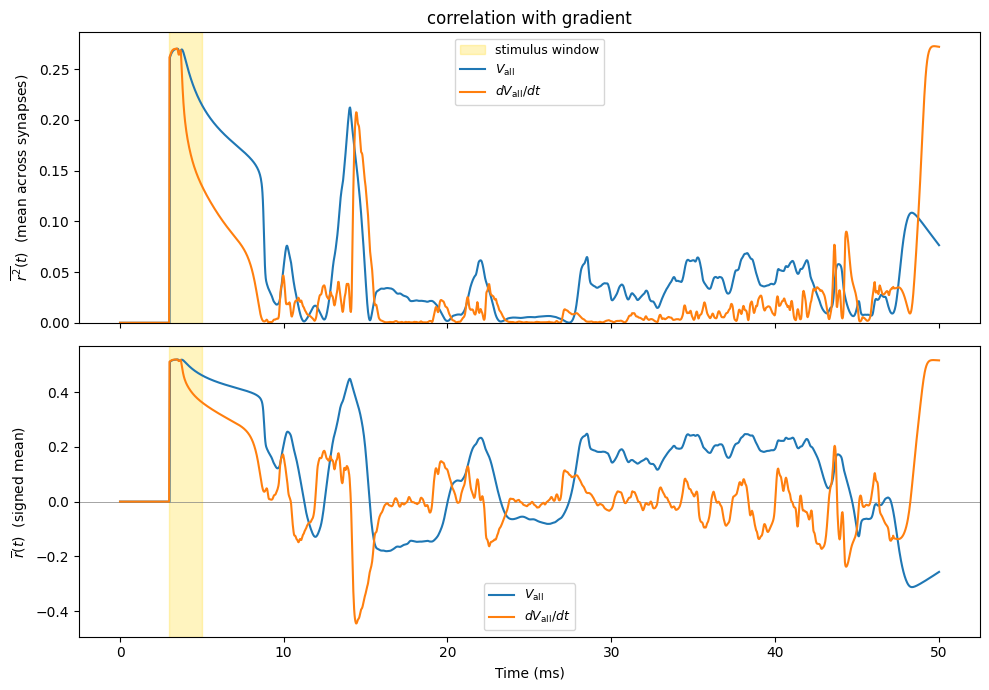

In [89]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

ax = axes[0]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus window")
ax.plot(t, mean_r2_v_all, label=r"$V_{\rm all}$", lw=1.5)
ax.plot(t, mean_r2_dvdt,   label=r"$dV_{\rm all}/dt$", lw=1.5)
ax.set_ylabel(r"$\overline{r^2}(t)$  (mean across synapses)")
ax.set_title("correlation with gradient")
ax.legend(fontsize=9)
ax.set_ylim(bottom=0)

ax = axes[1]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25)
ax.axhline(0, color="grey", lw=0.5)
ax.plot(t, mean_r_v_all, label=r"$V_{\rm all}$", lw=1.5)
ax.plot(t, mean_r_dvdt,   label=r"$dV_{\rm all}/dt$", lw=1.5)
ax.set_ylabel(r"$\overline{r}(t)$  (signed mean)")
ax.set_xlabel("Time (ms)")
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


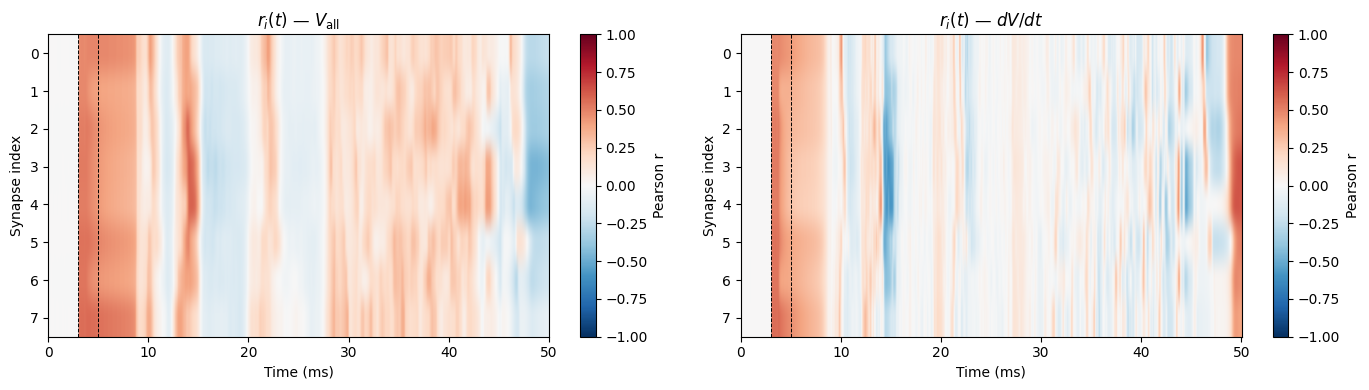

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, data, title in zip(
    axes,
    [r_v_all, r_dvdt],
    [r"$r_i(t)$ — $V_{\rm all}$", r"$r_i(t)$ — $dV/dt$"],
):
    im = ax.imshow(
        data,
        aspect="auto",
        cmap="RdBu_r",
        vmin=-1, vmax=1,
        extent=[t[0], t[-1], Nsyn - 0.5, - 0.5],
    )
    ax.axvline(i_delay, color="k", ls="--", lw=0.7)
    ax.axvline(i_delay + i_dur, color="k", ls="--", lw=0.7)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Synapse index")
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label="Pearson r")

plt.tight_layout()
plt.show()

So far just seems to be the case that the strongest possible predictive time is really early like near stimulus onset(or like the initial polarization)

also seems to be something happening later on, but not sure how to quantify? maybe more spiking/bAP? 


synapse specific credits vs global effect? I wonder if this is where you do off vs on diagonals? how to zone inmore to bap times etc

## Step 7b — Conditional correlation (ON vs OFF)

For each synapse $i$ and time $t$:

- pooled (computed above): $r_i(t) = \text{corr}(V_i(t), g_i)$ across all trials
- conditional ON: $r_i^{\text{on}}(t) = \text{corr}(V_i(t), g_i \mid p_i = 1)$
- conditional OFF: $r_i^{\text{off}}(t) = \text{corr}(V_i(t), g_i \mid p_i = 0)$


In [91]:
print("ON/OFF trial counts per synapse") # expect N/2 ON and N/2 OFF trials per synapse
on_counts = patterns.sum(axis=0).astype(int)   # (Nsyn,)
off_counts = N - on_counts
for i in range(Nsyn):
    print(f"synapse {i}: ON = {on_counts[i]:4d}, OFF = {off_counts[i]:4d}")

ON/OFF trial counts per synapse
synapse 0: ON =  238, OFF =  262
synapse 1: ON =  234, OFF =  266
synapse 2: ON =  248, OFF =  252
synapse 3: ON =  268, OFF =  232
synapse 4: ON =  237, OFF =  263
synapse 5: ON =  250, OFF =  250
synapse 6: ON =  237, OFF =  263
synapse 7: ON =  228, OFF =  272


In [92]:
def corr_1d(x, y, eps=1e-12):
    x = x - x.mean()
    y = y - y.mean()
    denom = np.sqrt((x @ x) * (y @ y)) + eps
    return (x @ y) / denom


def timecorr_conditional(VALL, GRADS, patterns, min_trials=20):
    N, Nsyn, T = VALL.shape
    r_on = np.full((Nsyn, T), np.nan)
    r_off = np.full((Nsyn, T), np.nan)

    for i in range(Nsyn):
        m_on = patterns[:, i].astype(bool)
        m_off = ~m_on

        # ON
        if m_on.sum() >= min_trials:
            y = GRADS[m_on, i]           # (N_on,)
            X = VALL[m_on, i, :]         # (N_on, T)
            # vectorised across time
            X_dm = X - X.mean(axis=0, keepdims=True)
            y_dm = y - y.mean()
            num = (X_dm * y_dm[:, None]).sum(axis=0)                     # (T,)
            denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
            r_on[i] = num / denom

        # OFF
        if m_off.sum() >= min_trials:
            y = GRADS[m_off, i]
            X = VALL[m_off, i, :]
            X_dm = X - X.mean(axis=0, keepdims=True)
            y_dm = y - y.mean()
            num = (X_dm * y_dm[:, None]).sum(axis=0)
            denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
            r_off[i] = num / denom

    return r_on, r_off


# conditional correlation
r_on, r_off = timecorr_conditional(VALL, GRADS, patterns)
print(f"r_on  shape: {r_on.shape},  finite: {np.isfinite(r_on).sum()}/{r_on.size}")
print(f"r_off shape: {r_off.shape},  finite: {np.isfinite(r_off).sum()}/{r_off.size}")

# also do dV/dt
r_on_dvdt, r_off_dvdt = timecorr_conditional(dVdt, GRADS, patterns)
print(f"r_on_dvdt  shape: {r_on_dvdt.shape}")
print(f"r_off_dvdt shape: {r_off_dvdt.shape}")


r_on  shape: (8, 2002),  finite: 16016/16016
r_off shape: (8, 2002),  finite: 16016/16016
r_on_dvdt  shape: (8, 2002)
r_off_dvdt shape: (8, 2002)


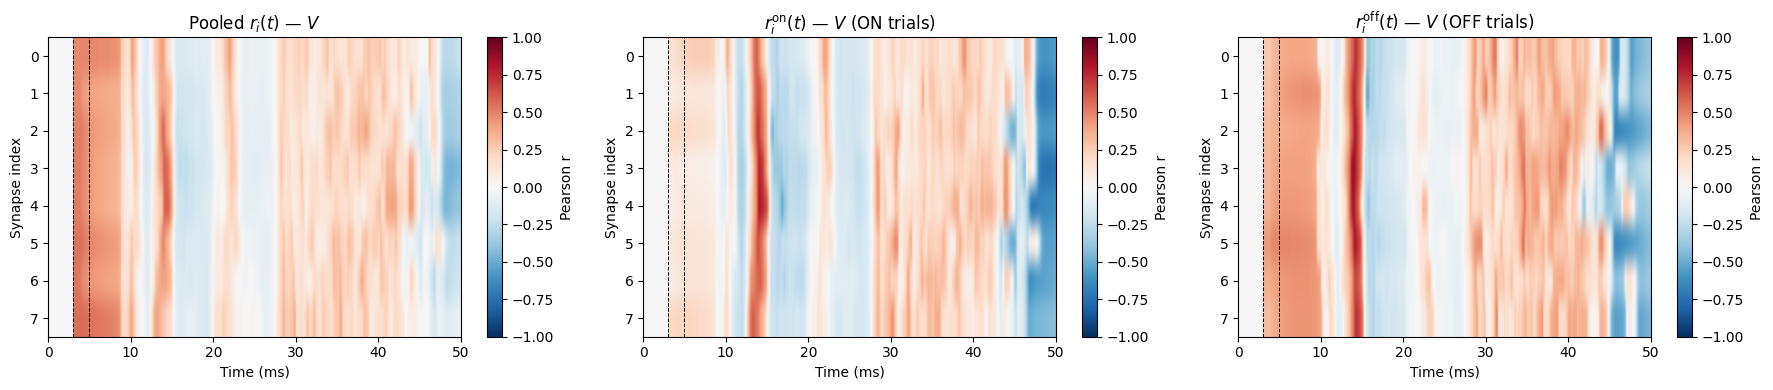

In [93]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for ax, data, title in zip(
    axes,
    [r_v_all, r_on, r_off],
    [r"Pooled $r_i(t)$ — $V$",
     r"$r_i^{\mathrm{on}}(t)$ — $V$ (ON trials)",
     r"$r_i^{\mathrm{off}}(t)$ — $V$ (OFF trials)"],
):
    im = ax.imshow(
        data, aspect="auto", cmap="RdBu_r",
        vmin=-1, vmax=1,
        extent=[t[0], t[-1], Nsyn - 0.5, -0.5],
    )
    ax.axvline(i_delay, color="k", ls="--", lw=0.7)
    ax.axvline(i_delay + i_dur, color="k", ls="--", lw=0.7)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Synapse index")
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label="Pearson r")

plt.tight_layout()
plt.show()


This may be a sign of global effects dominating. We are getting high r at 35ish ms even in the OFF condition. So it may be that the voltage at many sites/synapses is dominated by a shared postsynaptic event (spike/bAP/?) and the g_i covaries with these events because the loss is based on the somatic trace only. Also, the heatmaps look like vertical bands (similar timing across synapses) rather than very synapse specific timing so again hinting at some global effect.

We can check if g_i is actually varying in OFF trials. If gradients are near constant in OFF and we are correlating against tiny variance, correlations can become unstable. We can look at STD, if STDN grad OFF is non trivial, the OFF signal might be real (resynaptic OFF neurons still spike sometimes, or synapse i still has some effect). If it’s tiny, we have to treat OFF correlations with care and think about global effects. 

In [94]:
for i in range(8):
    m_on = patterns[:, i].astype(bool)
    m_off = ~m_on
    print(i,
          "std grad ON", GRADS[m_on, i].std(),
          "std grad OFF", GRADS[m_off, i].std(),
          "mean|grad| ON", np.mean(np.abs(GRADS[m_on, i])),
          "mean|grad| OFF", np.mean(np.abs(GRADS[m_off, i])))


0 std grad ON 41420948.82376145 std grad OFF 8435877.048633358 mean|grad| ON 37297858.37378704 mean|grad| OFF 6438556.610164828
1 std grad ON 46257580.860033415 std grad OFF 6586869.787267576 mean|grad| ON 40183559.4060495 mean|grad| OFF 5685748.5553870145
2 std grad ON 38306849.28032289 std grad OFF 7644468.160623304 mean|grad| ON 36822092.64389377 mean|grad| OFF 5798088.068540127
3 std grad ON 37564897.987522244 std grad OFF 6828928.651050018 mean|grad| ON 38449248.255827814 mean|grad| OFF 4940361.683175011
4 std grad ON 37775477.86334822 std grad OFF 7019203.857488549 mean|grad| ON 36987752.017384276 mean|grad| OFF 5622709.020780585
5 std grad ON 31329599.65715081 std grad OFF 8707634.898668356 mean|grad| ON 34936780.143839754 mean|grad| OFF 6190909.514545146
6 std grad ON 42353118.140287496 std grad OFF 6803945.0242616525 mean|grad| ON 42389478.41223138 mean|grad| OFF 5258241.768021543
7 std grad ON 40397424.13724152 std grad OFF 7856761.0482214345 mean|grad| ON 41884444.26933363 m

In [95]:
for i in range(8):
    m_off = ~patterns[:, i].astype(bool)
    vals = np.abs(GRADS[m_off, i])
    print(i, np.percentile(vals, [50, 90, 99]))


0 [ 2798119.65162156 18319904.83954721 39661009.59429071]
1 [ 3306552.39354592 14906386.01709909 27512516.05059019]
2 [ 2882120.2612282  16168461.68351891 34774218.50674804]
3 [ 2801149.33750413 15184887.19890116 30454017.90535722]
4 [ 2974406.89434403 19838026.88144574 23842131.0502656 ]
5 [ 2309317.74946061 19272691.7626405  36153402.75332677]
6 [ 2520158.79844158 17250669.1727121  27002621.65215296]
7 [ 2576779.85744941 18336927.78551225 30777146.11984849]


## Part 7C — Partial correlation controlling for the pattern

For each synapse $i$, time $t$:
1. Regress gradient out of patterns: $g_i \approx \beta^\top P$
2. Regress voltage out of patterns: $V_i(t) \approx \gamma(t)^\top P$
3. Correlate residuals: $r_i^{\text{partial}}(t) = \text{corr}(V_i(t) - \hat{V}_i(t),\; g_i - \hat{g}_i)$

In [96]:
# ordinary least squares regression of X on P 
# subtract the part of X that is explained by P!!!
def residualize_against_P(X, P):
    beta, *_ = np.linalg.lstsq(P, X, rcond=None)   # (K,) or (K, T)
    return X - P @ beta


def partial_timecorr(VALL, GRADS, patterns, add_hamming_weight=False):
    N, Nsyn, T = VALL.shape
    cols = [np.ones((N, 1)), patterns.astype(float)]
    if add_hamming_weight:
        cols.append(patterns.sum(axis=1, keepdims=True).astype(float)) # sum how many were ON for given pattern 
    P = np.concatenate(cols, axis=1)   # (N, K)
    print(f"Design matrix P shape: {P.shape} (K = {P.shape[1]})")

    r_partial = np.full((Nsyn, T), np.nan)
    for i in range(Nsyn):
        y_res = residualize_against_P(GRADS[:, i].astype(float), P)   # (N,)
        X_res = residualize_against_P(VALL[:, i, :].astype(float), P) # (N, T)
        # vectorised correlation across time
        X_dm = X_res - X_res.mean(axis=0, keepdims=True)
        y_dm = y_res - y_res.mean()
        num   = (X_dm * y_dm[:, None]).sum(axis=0)
        denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
        r_partial[i] = num / denom

    return r_partial

print("Partial correlation (P = [1, patterns]):")
r_partial = partial_timecorr(VALL, GRADS, patterns, add_hamming_weight=False)
print(f" r_partial shape: {r_partial.shape}")

print("\nPartial correlation (P = [1, patterns, Hamming weight]):")
r_partial_hw = partial_timecorr(VALL, GRADS, patterns, add_hamming_weight=False)
print(f"r_partial_hw shape: {r_partial_hw.shape}")

# dV/dt versions
print("\nPartial correlation on dV/dt:")
r_partial_dvdt = partial_timecorr(dVdt, GRADS, patterns, add_hamming_weight=False)
print(f" r_partial_dvdt shape: {r_partial_dvdt.shape}")


Partial correlation (P = [1, patterns]):
Design matrix P shape: (500, 9) (K = 9)
 r_partial shape: (8, 2002)

Partial correlation (P = [1, patterns, Hamming weight]):


Design matrix P shape: (500, 9) (K = 9)
r_partial_hw shape: (8, 2002)

Partial correlation on dV/dt:
Design matrix P shape: (500, 9) (K = 9)
 r_partial_dvdt shape: (8, 2002)


In [97]:
# ON 
def partial_timecorr_on(VALL, GRADS, patterns, min_trials=20):
    N, Nsyn, T = VALL.shape
    r_partial_on = np.full((Nsyn, T), np.nan)

    for i in range(Nsyn):
        m = patterns[:, i].astype(bool)
        n_on = m.sum()
        if n_on < min_trials:
            print(f"synapse {i}: skipped (only {n_on} ON trials)")
            continue
        mask_other = np.ones(Nsyn, dtype=bool)
        mask_other[i] = False

        P = np.concatenate([
            np.ones((n_on, 1)), patterns[m][:, mask_other].astype(float)],axis=1)  # (n_on, 1 + (Nsyn-1))

        y_res = residualize_against_P(GRADS[m, i].astype(float), P)
        X_res = residualize_against_P(VALL[m, i, :].astype(float), P)

        X_dm = X_res - X_res.mean(axis=0, keepdims=True)
        y_dm = y_res - y_res.mean()
        num   = (X_dm * y_dm[:, None]).sum(axis=0)
        denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
        r_partial_on[i] = num / denom

    return r_partial_on

def partial_timecorr_off(VALL, GRADS, patterns, min_trials=20):
    N, Nsyn, T = VALL.shape
    r_partial_off = np.full((Nsyn, T), np.nan)

    for i in range(Nsyn):
        m = ~patterns[:, i].astype(bool)   # OFF trials for synapse i
        n_off = m.sum()
        if n_off < min_trials:
            continue

        # regress out OTHER synapses' bits (drop i)
        mask_other = np.ones(Nsyn, dtype=bool)
        mask_other[i] = False
        P = np.concatenate(
            [np.ones((n_off, 1)), patterns[m][:, mask_other].astype(float)],
            axis=1
        )

        y_res = residualize_against_P(GRADS[m, i].astype(float), P)
        X_res = residualize_against_P(VALL[m, i, :].astype(float), P)

        X_dm = X_res - X_res.mean(axis=0, keepdims=True)
        y_dm = y_res - y_res.mean()
        num   = (X_dm * y_dm[:, None]).sum(axis=0)
        denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
        r_partial_off[i] = num / denom

    return r_partial_off



r_partial_on = partial_timecorr_on(VALL, GRADS, patterns)
print(f"r_partial_on shape: {r_partial_on.shape}")

r_partial_off = partial_timecorr_off(VALL, GRADS, patterns)
print(f"r_partial_off shape: {r_partial_off.shape}")

r_partial_off_dvdt = partial_timecorr(dVdt, GRADS, patterns)
print(f" r_partial__off_dvdt shape: {r_partial_off_dvdt.shape}")

r_partial_on_dvdt = partial_timecorr_on(dVdt, GRADS, patterns)
print(f"r_partial_on_dvdt shape: {r_partial_on_dvdt.shape}")


r_partial_on shape: (8, 2002)
r_partial_off shape: (8, 2002)
Design matrix P shape: (500, 9) (K = 9)
 r_partial__off_dvdt shape: (8, 2002)
r_partial_on_dvdt shape: (8, 2002)


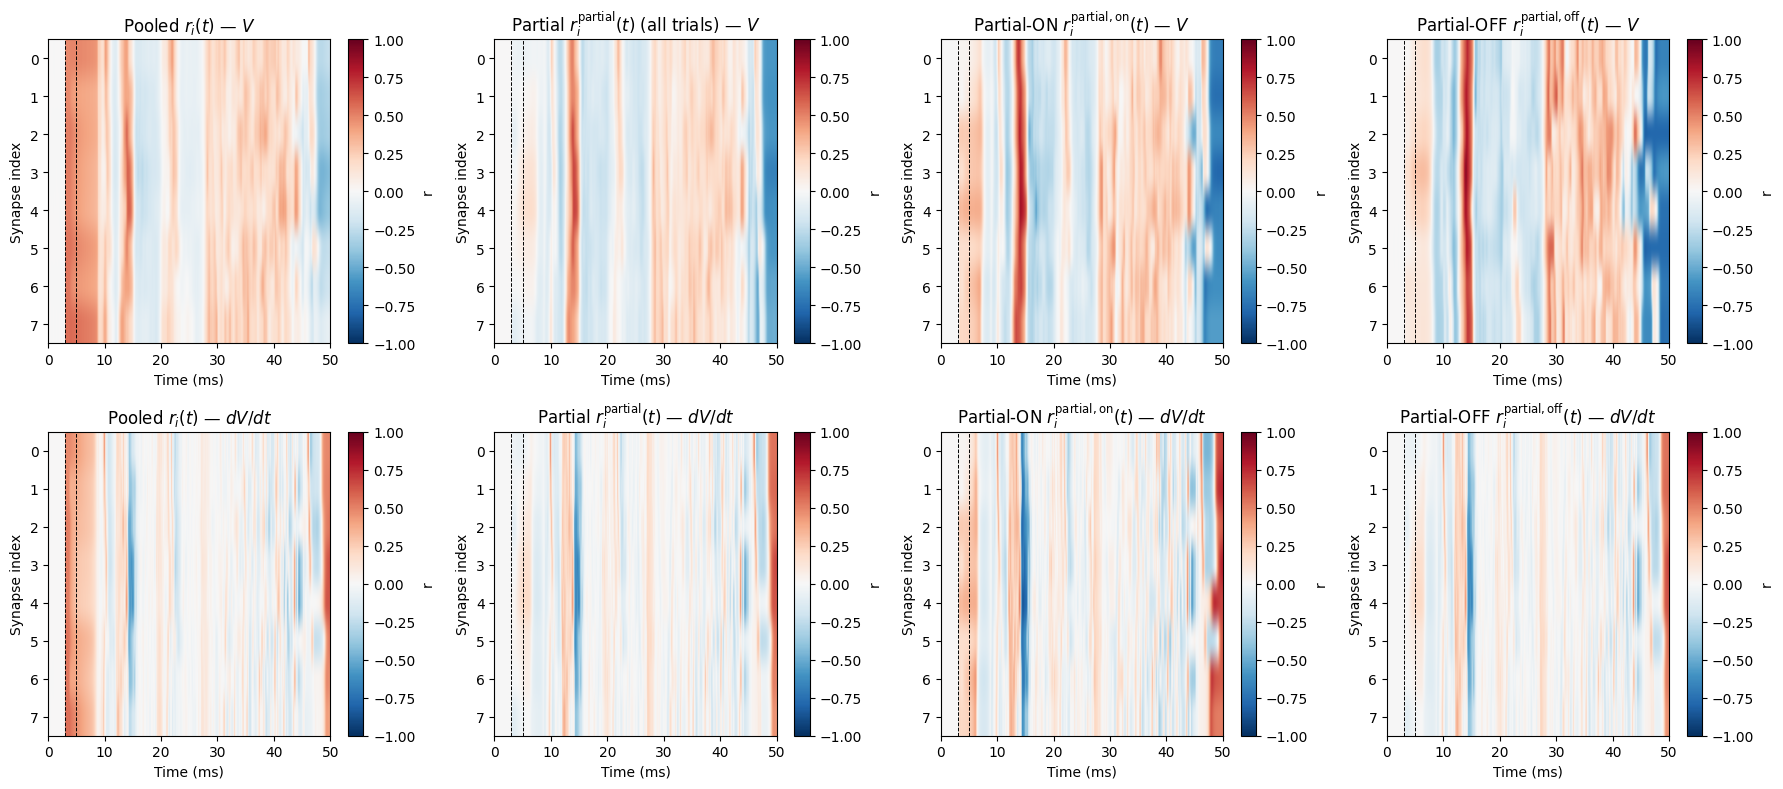

In [98]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))

# V
titles_top = [
    r"Pooled $r_i(t)$",
    r"Partial $r_i^{\mathrm{partial}}(t)$ (all trials)",
    r"Partial-ON $r_i^{\mathrm{partial,on}}(t)$",
    r"Partial-OFF $r_i^{\mathrm{partial,off}}(t)$",
]
datas_top = [r_v_all, r_partial, r_partial_on, r_partial_off]

for ax, data, title in zip(axes[0], datas_top, titles_top):
    im = ax.imshow(
        data, aspect="auto", cmap="RdBu_r",
        vmin=-1, vmax=1,
        extent=[t[0], t[-1], Nsyn - 0.5, -0.5],
    )
    ax.axvline(i_delay, color="k", ls="--", lw=0.7)
    ax.axvline(i_delay + i_dur, color="k", ls="--", lw=0.7)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Synapse index")
    ax.set_title(title + " — $V$")
    plt.colorbar(im, ax=ax, label="r")

# dVdt
titles_bot = [
    r"Pooled $r_i(t)$",
    r"Partial $r_i^{\mathrm{partial}}(t)$",
    r"Partial-ON $r_i^{\mathrm{partial,on}}(t)$",
    r"Partial-OFF $r_i^{\mathrm{partial,off}}(t)$",
]
datas_bot = [r_dvdt, r_partial_dvdt, r_partial_on_dvdt, r_partial_off_dvdt]

for ax, data, title in zip(axes[1], datas_bot, titles_bot):
    im = ax.imshow(
        data, aspect="auto", cmap="RdBu_r",
        vmin=-1, vmax=1,
        extent=[t[0], t[-1], Nsyn - 0.5, -0.5],
    )
    ax.axvline(i_delay, color="k", ls="--", lw=0.7)
    ax.axvline(i_delay + i_dur, color="k", ls="--", lw=0.7)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Synapse index")
    ax.set_title(title + " — $dV/dt$")
    plt.colorbar(im, ax=ax, label="r")

plt.tight_layout()
plt.show()


## Permutation test

We shuffle GRADS[:, i] across trials (within ON group for conditional analyses), we recompute peak $r^2$ in the stimulus window, and build a null distribution. 
- Pooled
- Conditional ON
- Partial (all trials)
- Partial ON


In [ ]:
def peak_r2_stim(r_mat, t_stim):
    return np.nanmax(r_mat[:, t_stim]**2, axis=1)   # (Nsyn,)


def permutation_test(VALL, GRADS, patterns, t_stim,
                     n_perm=1000, seed=42, min_trials=20):
    rng = np.random.default_rng(seed)
    N, Nsyn, T = VALL.shape

    # bserved peak r² 
    obs_pooled  = peak_r2_stim(r_v_all, t_stim)       # uses pre-computed
    obs_on = peak_r2_stim(r_on, t_stim)
    obs_partial = peak_r2_stim(r_partial, t_stim)
    obs_partial_on = peak_r2_stim(r_partial_on, t_stim)

    # null distributions
    null_pooled = np.zeros((n_perm, Nsyn))
    null_on = np.zeros((n_perm, Nsyn))
    null_partial = np.zeros((n_perm, Nsyn))
    null_partial_on = np.zeros((n_perm, Nsyn))

    # design matrix for partial (all trials)
    P_all = np.concatenate([np.ones((N, 1)), patterns.astype(float)], axis=1)

    for p in range(n_perm):
        if (p + 1) % 200 == 0:
            print(f"  permutation {p+1}/{n_perm}")

        # shuffle GRADS independently per synapse
        GRADS_shuf = GRADS.copy()
        for i in range(Nsyn):
            rng.shuffle(GRADS_shuf[:, i])

        for i in range(Nsyn):
            g_s = GRADS_shuf[:, i]

            # pooled
            X = VALL[:, i, t_stim]   # (N, T_stim)
            X_dm = X - X.mean(axis=0, keepdims=True)
            g_dm = g_s - g_s.mean()
            num   = (X_dm * g_dm[:, None]).sum(axis=0)
            denom = np.sqrt((X_dm**2).sum(axis=0) * (g_dm**2).sum()) + 1e-12
            null_pooled[p, i] = np.max((num / denom)**2)

            # conditional ON
            m_on = patterns[:, i].astype(bool)
            if m_on.sum() >= min_trials:
                y = g_s[m_on]
                X2 = VALL[m_on, i][:, t_stim]
                X2_dm = X2 - X2.mean(axis=0, keepdims=True)
                y_dm  = y - y.mean()
                num   = (X2_dm * y_dm[:, None]).sum(axis=0)
                denom = np.sqrt((X2_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
                null_on[p, i] = np.max((num / denom)**2)

            # partial (all trials)
            y_res = residualize_against_P(g_s.astype(float), P_all)
            X_res = residualize_against_P(VALL[:, i, t_stim].astype(float), P_all)
            X_dm = X_res - X_res.mean(axis=0, keepdims=True)
            y_dm = y_res - y_res.mean()
            num   = (X_dm * y_dm[:, None]).sum(axis=0)
            denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
            null_partial[p, i] = np.max((num / denom)**2)

            # partial ON
            if m_on.sum() >= min_trials:
              n_on = m_on.sum()
              P_on = np.concatenate(
                  [np.ones((n_on, 1)), patterns[m_on].astype(float)], axis=1
              )
              y_res = residualize_against_P(g_s[m_on].astype(float), P_on)
              X_res = residualize_against_P(VALL[m_on, i][:, t_stim].astype(float), P_on)
              X_dm = X_res - X_res.mean(axis=0, keepdims=True)
              y_dm = y_res - y_res.mean()
              num   = (X_dm * y_dm[:, None]).sum(axis=0)
              denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
              null_partial_on[p, i] = np.max((num / denom)**2)


    # p-values: fraction of null greater than observed
    pval_pooled = ((null_pooled >= obs_pooled[None, :]).sum(axis=0) + 1) / (n_perm + 1)
    pval_on  = ((null_on  >= obs_on[None, :]).sum(axis=0) + 1)  / (n_perm + 1)
    pval_partial = ((null_partial >= obs_partial[None, :]).sum(axis=0) + 1) / (n_perm + 1)
    pval_partial_on = ((null_partial_on >= obs_partial_on[None, :]).sum(axis=0) + 1) / (n_perm + 1)

    return dict(
        obs_pooled=obs_pooled, obs_on=obs_on,
        obs_partial=obs_partial, obs_partial_on=obs_partial_on,
        pval_pooled=pval_pooled, pval_on=pval_on,
        pval_partial=pval_partial, pval_partial_on=pval_partial_on,
    )


print("Running permutation test (n_perm=1000) ...")
perm = permutation_test(VALL, GRADS, patterns, t_stim, n_perm=1000)
print("Done!")


Running permutation test (n_perm=1000) ...


  permutation 200/1000
  permutation 400/1000
  permutation 600/1000
  permutation 800/1000
  permutation 1000/1000
Done!


In [111]:
# ── Display permutation test results ──
print("=" * 72)
print(f"{'Synapse':>8}  {'Pooled r²':>10} {'p':>7}  {'ON r²':>10} {'p':>7}  "
      f"{'Partial r²':>11} {'p':>7}  {'Part-ON r²':>11} {'p':>7}")
print("-" * 72)
for i in range(Nsyn):
    print(f"{i:>8d}  "
          f"{perm['obs_pooled'][i]:10.4f} {perm['pval_pooled'][i]:7.4f}  "
          f"{perm['obs_on'][i]:10.4f} {perm['pval_on'][i]:7.4f}  "
          f"{perm['obs_partial'][i]:11.4f} {perm['pval_partial'][i]:7.4f}  "
          f"{perm['obs_partial_on'][i]:11.4f} {perm['pval_partial_on'][i]:7.4f}")


 Synapse   Pooled r²       p       ON r²       p   Partial r²       p   Part-ON r²       p
------------------------------------------------------------------------
       0      0.2380  0.0010      0.0500  0.0010       0.0039  0.2168       0.0022  0.5894
       1      0.2306  0.0010      0.0121  0.1359       0.0006  0.7233       0.0112  0.1638
       2      0.2686  0.0010      0.0442  0.0010       0.0080  0.0709       0.0760  0.0010
       3      0.2716  0.0010      0.0076  0.2258       0.0094  0.0579       0.0674  0.0010
       4      0.2649  0.0010      0.0092  0.2068       0.0175  0.0060       0.1262  0.0010
       5      0.2990  0.0010      0.0210  0.0460       0.0044  0.2128       0.0333  0.0040
       6      0.2891  0.0010      0.0157  0.0579       0.0004  0.7932       0.0708  0.0010
       7      0.3196  0.0010      0.0475  0.0030       0.0123  0.0120       0.0499  0.0020


p < 0.05 indicates that peak r² in the stimulus window is
unlikely under the null (shuffled gradients).

Syn 0: pooled + ON significant, but partial and part-ON not → looks mostly like pattern/mixture effect, not robust within ON beyond context.

Syn 1: pooled significant, everything else not → almost entirely pattern/mixture.

Syn 2: part-ON strong (0.076, p=0.001), ON also strong → good evidence for within-ON signal; partial borderline.

Syn 3: ON not significant, part-ON strong → suggests the effect is there but gets masked unless you control for other-synapse context (classic confounding/suppression).

Syn 4: partial significant and part-ON very strong (0.126) → this synapse has a robust relationship even across all trials after pattern control, and especially within ON.

Syn 5: ON and part-ON significant, partial not → within-ON signal exists; pooled was mostly mixture.

Syn 6: ON borderline, part-ON strong → again, controlling for context reveals the relationship.

Syn 7: everything is significant (pooled, ON, partial, part-ON) → strongest/most consistent evidence.

## Step 7d — Full cross-correlation matrix $R_{i,j}(t)$

$$R_{i,j}(t) = \operatorname{corr}_{\text{trials}}\!\big(V_j(t),\; g_i\big)$$

- If credit is local: $R_{i,i}(t)$ should dominate off-diagonals.
- If it's global: vertical structure across many $j$'s for a fixed $i$.


In [113]:
def crosscorr_time(VALL, GRADS, eps=1e-12):
    N, J, T = VALL.shape
    I = GRADS.shape[1]

    Y = GRADS - GRADS.mean(axis=0, keepdims=True)    # (N, I)
    X = VALL  - VALL.mean(axis=0, keepdims=True)      # (N, J, T)

    num = np.einsum("ni,njt->ijt", Y, X)              # (I, J, T)
    sy  = np.sqrt((Y**2).sum(axis=0)) + eps           # (I,)
    sx  = np.sqrt((X**2).sum(axis=0)) + eps           # (J, T)

    R = num / (sy[:, None, None] * sx[None, :, :])    # (I, J, T)
    return R


R_cross = crosscorr_time(VALL, GRADS)
print(f"R_cross shape: {R_cross.shape}")  # (8, 8, 2002)

# dV/dt
R_cross_dvdt = crosscorr_time(dVdt, GRADS)
print(f"R_cross_dvdt shape: {R_cross_dvdt.shape}")


R_cross shape: (8, 8, 2002)
R_cross_dvdt shape: (8, 8, 2002)


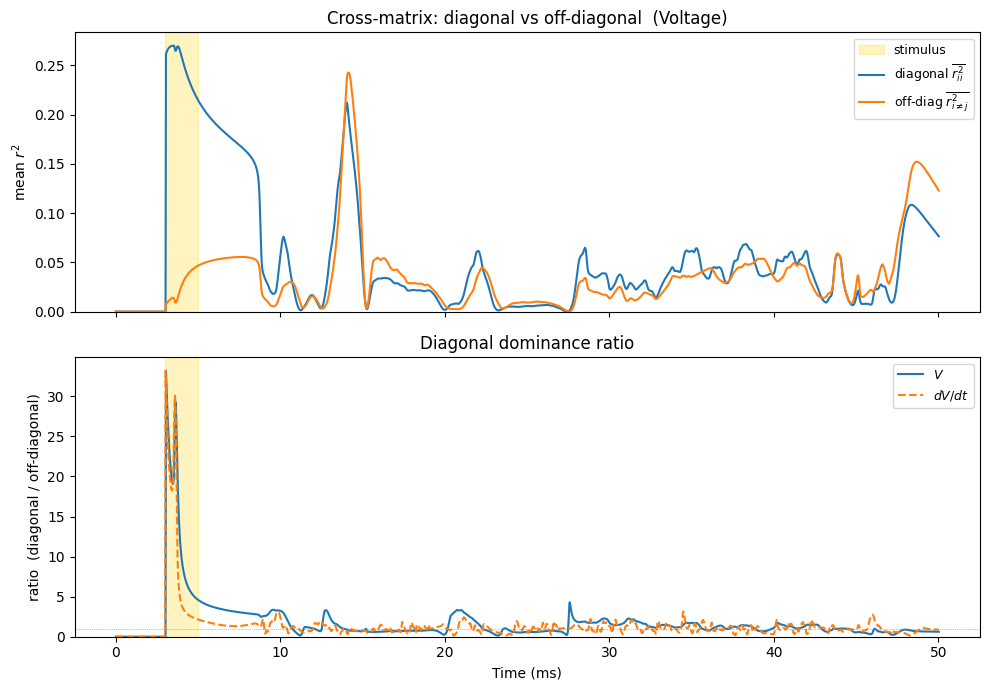

In [115]:
def diag_off_summary(R):
    I, J, T = R.shape
    assert I == J, "R must be square in first two dims"

    diag = np.array([R[i, i, :] for i in range(I)])       # (I, T)
    flat = R.reshape(I * J, T)
    off_mask = np.ones(I * J, dtype=bool)
    off_mask[np.arange(I) * J + np.arange(I)] = False
    off = flat[off_mask]                                   # (I*J - I, T)

    diag_m = (diag**2).mean(axis=0)                        # (T,)
    off_m  = (off**2).mean(axis=0)                         # (T,)
    ratio  = diag_m / (off_m + 1e-12)
    return diag_m, off_m, ratio


diag_m, off_m, ratio = diag_off_summary(R_cross)
diag_m_dv, off_m_dv, ratio_dv = diag_off_summary(R_cross_dvdt)

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

ax = axes[0]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus")
ax.plot(t, diag_m,  label=r"diagonal $\overline{r_{ii}^2}$", lw=1.5)
ax.plot(t, off_m,   label=r"off-diag $\overline{r_{i \neq j}^2}$", lw=1.5)
ax.set_ylabel(r"mean $r^2$")
ax.set_title("Cross-matrix: diagonal vs off-diagonal  (Voltage)")
ax.legend(fontsize=9)
ax.set_ylim(bottom=0)

ax = axes[1]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25)
ax.plot(t, ratio,    label=r"$V$", lw=1.5)
ax.plot(t, ratio_dv, label=r"$dV/dt$", lw=1.5, ls="--")
ax.axhline(1, color="grey", lw=0.5, ls=":")
ax.set_ylabel("ratio  (diagonal / off-diagonal)")
ax.set_xlabel("Time (ms)")
ax.set_title("Diagonal dominance ratio")
ax.legend(fontsize=9)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()


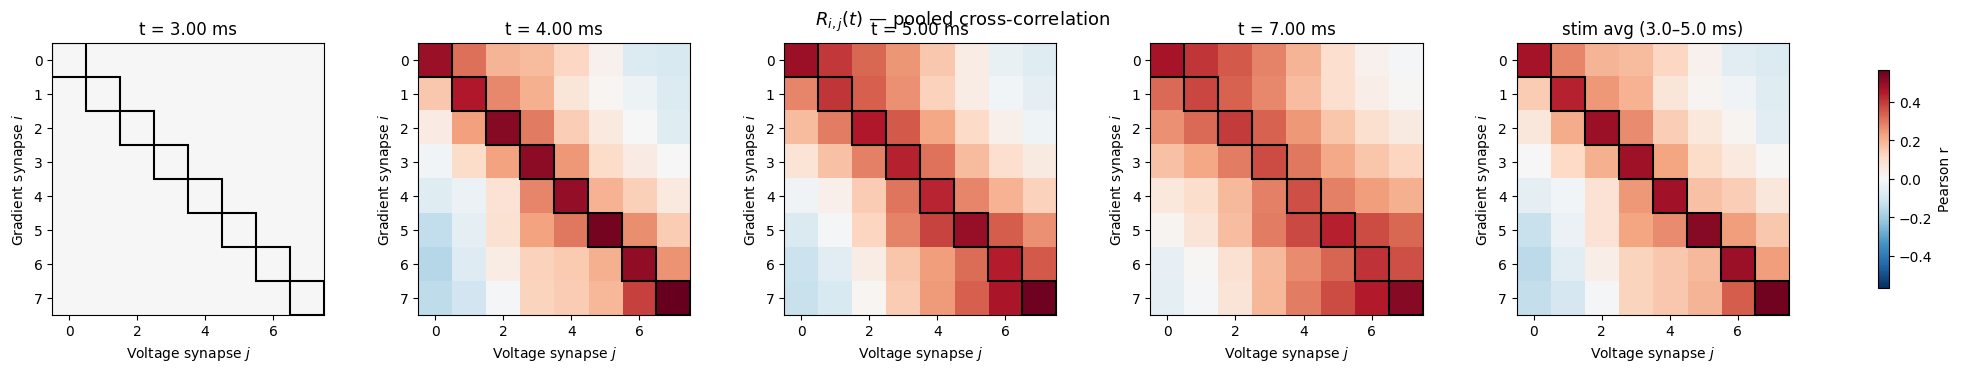

In [112]:
# ── Heatmap snapshots of R_{i,j} at key timepoints + stimulus-window average ──
# Pick a few representative timepoints
t_snap_ms = [i_delay, i_delay + i_dur / 2, i_delay + i_dur, i_delay + i_dur + 2]
t_snap_idx = [np.argmin(np.abs(t - ts)) for ts in t_snap_ms]

# Stimulus-window average
R_stim_avg = R_cross[:, :, t_stim].mean(axis=2)   # (I, J)

n_panels = len(t_snap_idx) + 1  # snapshots + stim average
fig, axes = plt.subplots(1, n_panels, figsize=(4 * n_panels, 3.5),
                         constrained_layout=True)

vmax = np.max(np.abs(R_cross[:, :, t_stim]))  # adaptive color scale

for k, (ax, tidx) in enumerate(zip(axes[:-1], t_snap_idx)):
    im = ax.imshow(R_cross[:, :, tidx], cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    ax.set_title(f"t = {t[tidx]:.2f} ms")
    ax.set_xlabel("Voltage synapse $j$")
    ax.set_ylabel("Gradient synapse $i$")
    # highlight diagonal
    for d in range(Nsyn):
        ax.add_patch(plt.Rectangle((d - 0.5, d - 0.5), 1, 1,
                                    fill=False, ec="k", lw=1.5))

# Stimulus-window average
ax = axes[-1]
im = ax.imshow(R_stim_avg, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
ax.set_title(f"stim avg ({i_delay}–{i_delay+i_dur} ms)")
ax.set_xlabel("Voltage synapse $j$")
ax.set_ylabel("Gradient synapse $i$")
for d in range(Nsyn):
    ax.add_patch(plt.Rectangle((d - 0.5, d - 0.5), 1, 1,
                                fill=False, ec="k", lw=1.5))

plt.colorbar(im, ax=axes.tolist(), label="Pearson r", shrink=0.8)
fig.suptitle(r"$R_{i,j}(t)$ — pooled cross-correlation", fontsize=13, y=1.02)
plt.show()


## Step 2 — Partial-ON cross-correlation matrix $R_{i,j}^{\text{partial,on}}(t)$

For each gradient synapse $i$:
1. Restrict to ON trials for synapse $i$
2. Residualize $g_i$ and every $V_j(t)$ against pattern bits
3. Compute $R_{i,j}^{\text{partial,on}}(t) = \operatorname{corr}(\text{resid}(V_j(t)),\; \text{resid}(g_i))$

This is the strongest test: does **local** voltage at synapse $j$ explain the gradient at synapse $i$, within ON trials and beyond pattern context?


In [105]:
# ── Partial-ON cross-correlation matrix ──
def crosscorr_partial_on(VALL, GRADS, patterns, min_trials=20, eps=1e-12):
    """
    Partial-ON cross-correlation matrix R_{i,j}^{partial,on}(t).

    For each gradient synapse i:
      - restrict to ON trials for synapse i
      - build design matrix P = [1, patterns] (from those trials)
      - residualize g_i and every V_j(t) against P
      - correlate residuals

    Returns R_partial_on : (I, J, T)
    """
    N, J, T = VALL.shape
    I = GRADS.shape[1]
    R_partial_on = np.full((I, J, T), np.nan)

    for i in range(I):
        m = patterns[:, i].astype(bool)
        n_on = m.sum()
        if n_on < min_trials:
            print(f"  gradient synapse {i}: skipped ({n_on} ON trials)")
            continue

        # Design matrix: intercept + other pattern bits
        mask_other = np.ones(I, dtype=bool)
        mask_other[i] = False
        P = np.concatenate([
            np.ones((n_on, 1)),
            patterns[m][:, mask_other].astype(float)
        ], axis=1)  # (n_on, 1 + (Nsyn-1))

        # Residualize gradient
        y_res = residualize_against_P(GRADS[m, i].astype(float), P)  # (n_on,)
        y_dm  = y_res - y_res.mean()

        for j in range(J):
            # Residualize voltage at synapse j
            X_res = residualize_against_P(VALL[m, j, :].astype(float), P)  # (n_on, T)
            X_dm  = X_res - X_res.mean(axis=0, keepdims=True)

            num   = (X_dm * y_dm[:, None]).sum(axis=0)                     # (T,)
            denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + eps
            R_partial_on[i, j, :] = num / denom

    return R_partial_on


R_partial_on_cross = crosscorr_partial_on(VALL, GRADS, patterns)
print(f"R_partial_on_cross shape: {R_partial_on_cross.shape}")  # (8, 8, 2002)


R_partial_on_cross shape: (8, 8, 2002)


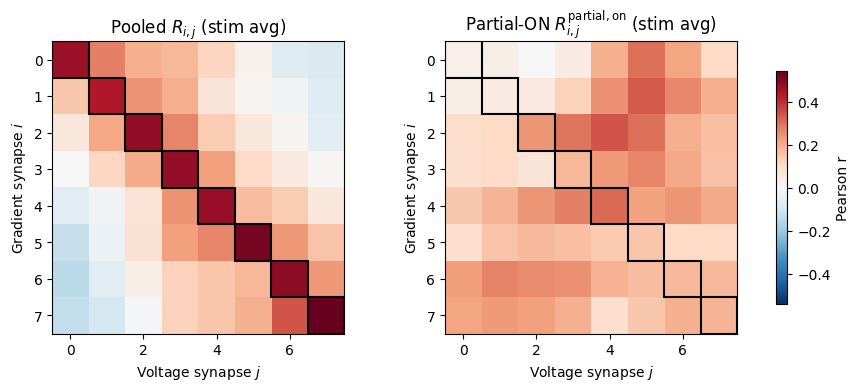

In [116]:
# ── Heatmap snapshots: pooled vs partial-ON cross-matrix ──
R_po_stim_avg = np.nanmean(R_partial_on_cross[:, :, t_stim], axis=2)  # (I, J)

fig, axes = plt.subplots(1, 2, figsize=(9, 3.8),
                         constrained_layout=True)

vmax2 = max(np.nanmax(np.abs(R_stim_avg)),
            np.nanmax(np.abs(R_po_stim_avg)))

for ax, mat, title in zip(
    axes,
    [R_stim_avg, R_po_stim_avg],
    [r"Pooled $R_{i,j}$ (stim avg)",
     r"Partial-ON $R_{i,j}^{\mathrm{partial,on}}$ (stim avg)"],
):
    im = ax.imshow(mat, cmap="RdBu_r", vmin=-vmax2, vmax=vmax2)
    ax.set_xlabel("Voltage synapse $j$")
    ax.set_ylabel("Gradient synapse $i$")
    ax.set_title(title)
    for d in range(Nsyn):
        ax.add_patch(plt.Rectangle((d - 0.5, d - 0.5), 1, 1,
                                    fill=False, ec="k", lw=1.5))

plt.colorbar(im, ax=axes.tolist(), label="Pearson r", shrink=0.8)
plt.show()


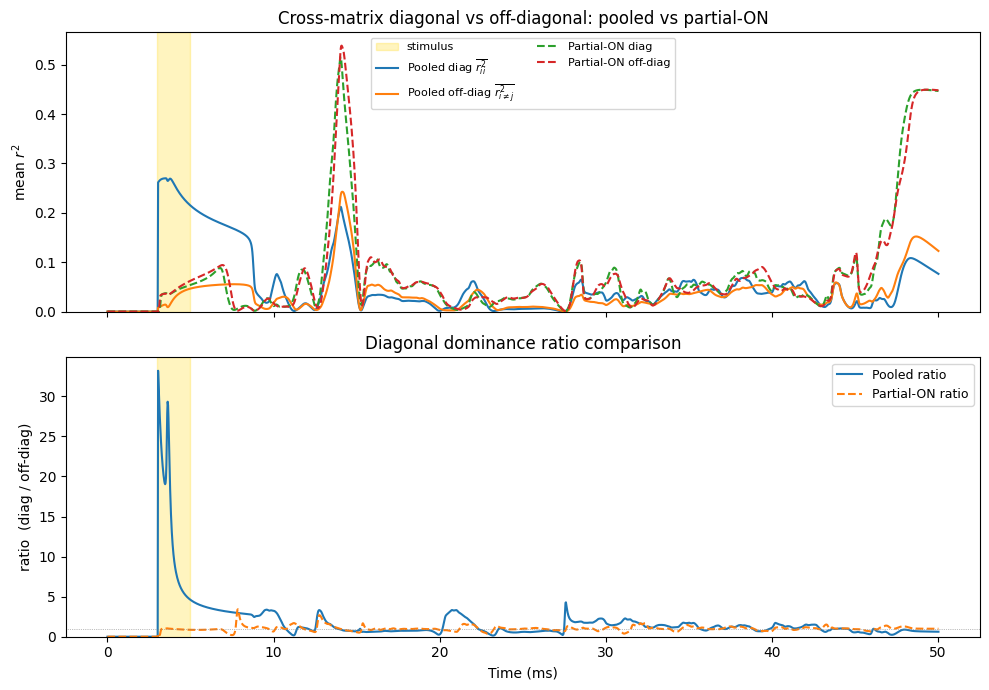

In [107]:
# ── Diagonal dominance: pooled vs partial-ON ──
diag_po, off_po, ratio_po = diag_off_summary(
    np.nan_to_num(R_partial_on_cross, nan=0.0)
)

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

ax = axes[0]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus")
ax.plot(t, diag_m,  label=r"Pooled diag $\overline{r_{ii}^2}$",       lw=1.5)
ax.plot(t, off_m,   label=r"Pooled off-diag $\overline{r_{i\neq j}^2}$", lw=1.5)
ax.plot(t, diag_po, label=r"Partial-ON diag",   lw=1.5, ls="--")
ax.plot(t, off_po,  label=r"Partial-ON off-diag", lw=1.5, ls="--")
ax.set_ylabel(r"mean $r^2$")
ax.set_title("Cross-matrix diagonal vs off-diagonal: pooled vs partial-ON")
ax.legend(fontsize=8, ncol=2)
ax.set_ylim(bottom=0)

ax = axes[1]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25)
ax.plot(t, ratio,    label="Pooled ratio", lw=1.5)
ax.plot(t, ratio_po, label="Partial-ON ratio", lw=1.5, ls="--")
ax.axhline(1, color="grey", lw=0.5, ls=":")
ax.set_ylabel("ratio  (diag / off-diag)")
ax.set_xlabel("Time (ms)")
ax.set_title("Diagonal dominance ratio comparison")
ax.legend(fontsize=9)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()


## Step 3 — Windowed effect-size metrics

Replace "max $r^2$" with more stable windowed metrics in the stimulus window:
- **Mean $r^2$** in stimulus window
- **AUC** (area under the $r^2(t)$ curve) in stimulus window

These are less sensitive to a single noisy time bin.


In [108]:
# ── Windowed effect-size metrics ──
def windowed_metrics(r_mat, t_stim, dt):
    """
    Compute mean r² and AUC(r²) in stimulus window per synapse.

    r_mat   : (Nsyn, T)
    t_stim  : bool mask (T,)
    dt      : timestep in ms
    Returns mean_r2 (Nsyn,), auc_r2 (Nsyn,)
    """
    r2_stim = r_mat[:, t_stim]**2                    # (Nsyn, T_stim)
    mean_r2 = np.nanmean(r2_stim, axis=1)            # (Nsyn,)
    auc_r2  = np.nansum(r2_stim, axis=1) * dt        # (Nsyn,)  [ms·r²]
    return mean_r2, auc_r2


# Compute for all analysis variants
metrics = {}
for name, r_mat in [
    ("pooled",       r_v_all),
    ("cond_ON",      r_on),
    ("cond_OFF",     r_off),
    ("partial",      r_partial),
    ("partial_on",   r_partial_on),
]:
    m_r2, a_r2 = windowed_metrics(r_mat, t_stim, dt)
    metrics[name] = {"mean_r2": m_r2, "auc_r2": a_r2}

# Also for diagonal / off-diagonal of cross-matrix
diag_cross = np.array([R_cross[i, i, :] for i in range(Nsyn)])         # (Nsyn, T)
off_cross  = np.nanmean(np.array([
    [R_cross[i, j, :] for j in range(Nsyn) if j != i]
    for i in range(Nsyn)
]), axis=1)  # (Nsyn, T) — mean off-diagonal per gradient synapse

m_diag, a_diag = windowed_metrics(diag_cross, t_stim, dt)
m_off,  a_off  = windowed_metrics(off_cross,  t_stim, dt)
metrics["cross_diag"]    = {"mean_r2": m_diag, "auc_r2": a_diag}
metrics["cross_offdiag"] = {"mean_r2": m_off,  "auc_r2": a_off}

# ── Print summary table ──
print("=" * 90)
print(f"{'Analysis':<16} | {'Synapse':<8} | {'max r²':>8} | {'mean r²':>9} | {'AUC r²':>10}")
print("-" * 90)
for name in ["pooled", "cond_ON", "partial", "partial_on", "cross_diag", "cross_offdiag"]:
    r_mat_lookup = {
        "pooled": r_v_all, "cond_ON": r_on, "partial": r_partial,
        "partial_on": r_partial_on, "cross_diag": diag_cross,
        "cross_offdiag": off_cross,
    }
    for i in range(Nsyn):
        peak = np.nanmax(r_mat_lookup[name][i, t_stim]**2)
        mr2  = metrics[name]["mean_r2"][i]
        auc  = metrics[name]["auc_r2"][i]
        syn_label = f"  syn {i}" if i > 0 else f"  syn {i}"
        prefix = f"{name:<16}" if i == 0 else f"{'':16}"
        print(f"{prefix} | {syn_label:<8} | {peak:8.4f} | {mr2:9.4f} | {auc:10.4f}")
    print("-" * 90)
print("=" * 90)


Analysis         | Synapse  |   max r² |   mean r² |     AUC r²
------------------------------------------------------------------------------------------
pooled           |   syn 0  |   0.2380 |    0.2272 |     0.4600
                 |   syn 1  |   0.2306 |    0.1962 |     0.3974
                 |   syn 2  |   0.2686 |    0.2398 |     0.4857
                 |   syn 3  |   0.2716 |    0.2370 |     0.4799
                 |   syn 4  |   0.2649 |    0.2312 |     0.4681
                 |   syn 5  |   0.2990 |    0.2730 |     0.5529
                 |   syn 6  |   0.2891 |    0.2424 |     0.4908
                 |   syn 7  |   0.3196 |    0.3032 |     0.6140
------------------------------------------------------------------------------------------
cond_ON          |   syn 0  |   0.0500 |    0.0300 |     0.0607
                 |   syn 1  |   0.0121 |    0.0085 |     0.0172
                 |   syn 2  |   0.0442 |    0.0404 |     0.0818
                 |   syn 3  |   0.0076 |    0.0068

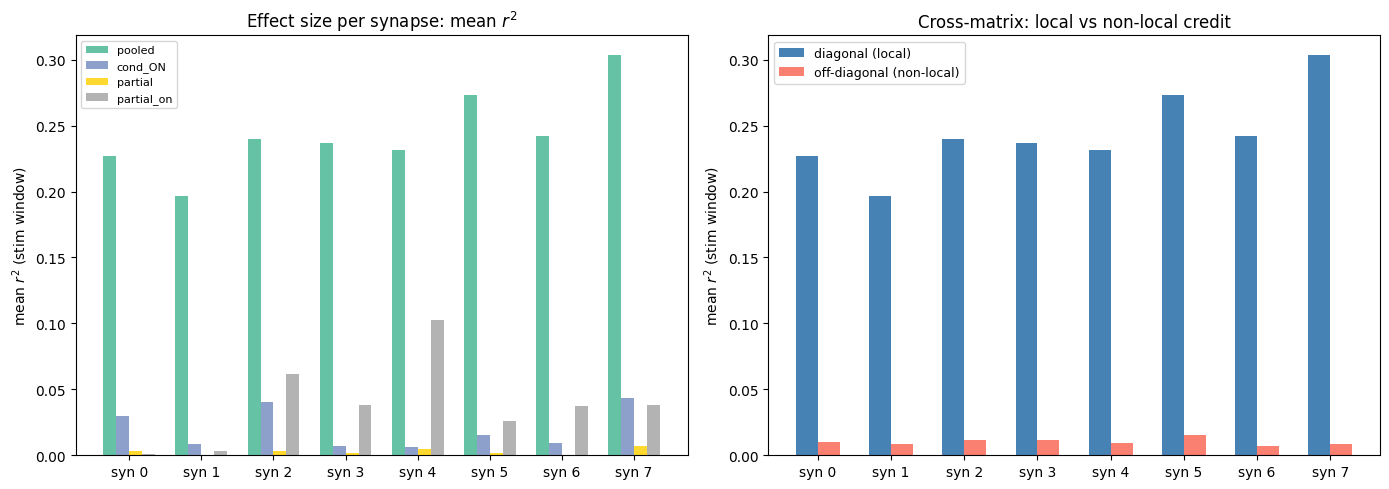

In [109]:
# ── Bar chart: mean r² in stimulus window across analyses ──
analysis_names = ["pooled", "cond_ON", "partial", "partial_on"]
colors = plt.cm.Set2(np.linspace(0, 1, len(analysis_names)))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- per-synapse mean r² ---
ax = axes[0]
x = np.arange(Nsyn)
width = 0.18
for k, name in enumerate(analysis_names):
    vals = metrics[name]["mean_r2"]
    ax.bar(x + k * width, vals, width, label=name, color=colors[k])
ax.set_xticks(x + width * (len(analysis_names) - 1) / 2)
ax.set_xticklabels([f"syn {i}" for i in range(Nsyn)])
ax.set_ylabel(r"mean $r^2$ (stim window)")
ax.set_title("Effect size per synapse: mean $r^2$")
ax.legend(fontsize=8)

# --- cross-matrix diag vs off-diag ---
ax = axes[1]
ax.bar(x - 0.15, metrics["cross_diag"]["mean_r2"],    0.3,
       label="diagonal (local)", color="steelblue")
ax.bar(x + 0.15, metrics["cross_offdiag"]["mean_r2"], 0.3,
       label="off-diagonal (non-local)", color="salmon")
ax.set_xticks(x)
ax.set_xticklabels([f"syn {i}" for i in range(Nsyn)])
ax.set_ylabel(r"mean $r^2$ (stim window)")
ax.set_title("Cross-matrix: local vs non-local credit")
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


In [110]:
# ── Save cross-matrix + windowed metrics ──
save_C = os.path.join("/n/home12/isanchez/jaxneuro/outputs", "analysis_cross_windowed.npz")

# Flatten metrics dict for saving
metrics_flat = {}
for name, d in metrics.items():
    for k, v in d.items():
        metrics_flat[f"metric_{name}_{k}"] = v

np.savez(
    save_C,
    # Step 1: pooled cross-matrix
    R_cross=R_cross,                   # (I, J, T)
    R_cross_dvdt=R_cross_dvdt,
    R_stim_avg=R_stim_avg,             # (I, J)
    diag_m=diag_m, off_m=off_m, ratio=ratio,   # (T,) each
    # Step 2: partial-ON cross-matrix
    R_partial_on_cross=R_partial_on_cross,      # (I, J, T)
    R_po_stim_avg=R_po_stim_avg,                # (I, J)
    diag_po=diag_po, off_po=off_po, ratio_po=ratio_po,
    # Step 3: windowed metrics
    **metrics_flat,
    # Metadata
    t=t,
)
print(f"✓ Saved → {save_C}  ({os.path.getsize(save_C)/1e6:.1f} MB)")


✓ Saved → /n/home12/isanchez/jaxneuro/outputs/analysis_cross_windowed.npz  (3.2 MB)


# Deliverable 1 — Per-trial scalar voltage feature $\mu_{n,i}$

**Option A** (stimulus-window mean):
$$\mu_{n,i} = \frac{1}{|W|}\sum_{t\in W} V_{n,i}(t)$$

**Option B** (kernel-weighted summary around peak time):
$$\mu_{n,i} = \sum_t K(t;\,t_0,\sigma)\,V_{n,i}(t)$$


In [117]:
# ── Option A: stimulus-window mean ──
# MU_mean[n, i] = mean of V_{n,i}(t) over stimulus window W
MU_mean = VALL[:, :, t_stim].mean(axis=2)  # (N, Nsyn)
print(f"MU_mean shape: {MU_mean.shape}")
print(f"MU_mean range: [{MU_mean.min():.3f}, {MU_mean.max():.3f}]")
print(f"MU_mean per-synapse means: {MU_mean.mean(axis=0).round(3)}")

# ── Option B: kernel-weighted summary ──
# Find peak time for each synapse from partial-ON r² in stim window
# Use the time of peak |r_partial_on| within the stimulus window as t0

# r_partial_on was computed earlier: (Nsyn, T)
r2_po_stim = r_partial_on[:, t_stim] ** 2   # (Nsyn, |W|)
t_stim_vals = t[t_stim]                       # (|W|,)

# Per-synapse peak time
t0_per_syn = np.array([t_stim_vals[np.nanargmax(r2_po_stim[i])]
                       for i in range(Nsyn)])
# Also define a global t0 as the time of peak mean r² across synapses
t0_global = t_stim_vals[np.nanargmax(np.nanmean(r2_po_stim, axis=0))]

sigma = 2.0  # ms — kernel width

print(f"\nKernel parameters:")
print(f"  sigma = {sigma} ms")
print(f"  t0 per synapse = {t0_per_syn.round(3)}")
print(f"  t0 global      = {t0_global:.3f} ms")

# Gaussian kernel (normalised to sum=1)
def gaussian_kernel(t_arr, t0, sigma):
    k = np.exp(-0.5 * ((t_arr - t0) / sigma) ** 2)
    return k / k.sum()

# Compute MU_kernel using per-synapse t0
MU_kernel = np.zeros((N, Nsyn))
for i in range(Nsyn):
    K_i = gaussian_kernel(t, t0_per_syn[i], sigma)  # (T,)
    MU_kernel[:, i] = (VALL[:, i, :] * K_i[None, :]).sum(axis=1)

print(f"\nMU_kernel shape: {MU_kernel.shape}")
print(f"MU_kernel range: [{MU_kernel.min():.3f}, {MU_kernel.max():.3f}]")
print(f"MU_kernel per-synapse means: {MU_kernel.mean(axis=0).round(3)}")


MU_mean shape: (500, 8)
MU_mean range: [-66.360, -63.948]
MU_mean per-synapse means: [-65.128 -65.276 -65.335 -65.353 -65.374 -65.338 -65.275 -65.14 ]

Kernel parameters:
  sigma = 2.0 ms
  t0 per synapse = [5.  5.  3.2 5.  5.  5.  5.  5. ]
  t0 global      = 5.000 ms

MU_kernel shape: (500, 8)
MU_kernel range: [-66.878, -57.851]
MU_kernel per-synapse means: [-62.636 -62.794 -65.689 -62.892 -62.917 -62.877 -62.804 -62.661]


# Deliverable 2 — Pattern lookup table

For each unique pattern $s$ in the 500 trials, compute:
- `count(s)` — number of trials with that pattern
- `k(s)` — Hamming weight (number of ON synapses)
- $\bar\mu_i(s)$ — mean voltage feature over trials with that pattern
- $\bar g_i(s)$ — mean gradient over trials with that pattern


In [118]:
import pandas as pd

# Convert each binary pattern to an integer (0–255)
pattern_ints = np.array([int("".join(row.astype(int).astype(str)), 2)
                         for row in patterns])  # (N,)

# Build lookup table
unique_pats, inverse, counts = np.unique(pattern_ints, return_inverse=True,
                                         return_counts=True)
n_unique = len(unique_pats)

rows = []
for idx, pat_int in enumerate(unique_pats):
    mask = inverse == idx
    pat_bits = patterns[mask][0]  # representative binary pattern
    k = int(pat_bits.sum())       # Hamming weight

    mu_bar = MU_mean[mask].mean(axis=0)   # (Nsyn,)
    g_bar  = GRADS[mask].mean(axis=0)     # (Nsyn,)

    row = {
        "pattern_int": pat_int,
        "pattern_bits": "".join(pat_bits.astype(int).astype(str)),
        "count": counts[idx],
        "k": k,
    }
    for i in range(Nsyn):
        row[f"mu_bar_{i}"] = mu_bar[i]
    for i in range(Nsyn):
        row[f"g_bar_{i}"] = g_bar[i]
    rows.append(row)

pattern_table = pd.DataFrame(rows)
pattern_table = pattern_table.sort_values("pattern_int").reset_index(drop=True)

print(f"Number of unique patterns observed: {n_unique} / {2**Nsyn} possible")
print(f"Count distribution:  min={counts.min()}, median={int(np.median(counts))}, "
      f"max={counts.max()}, mean={counts.mean():.1f}")
print(f"\nPattern table shape: {pattern_table.shape}")
print(pattern_table.head(10).to_string(index=False))
print("...")
print(pattern_table.tail(5).to_string(index=False))


Number of unique patterns observed: 215 / 256 possible
Count distribution:  min=1, median=2, max=6, mean=2.3

Pattern table shape: (215, 20)
 pattern_int pattern_bits  count  k   mu_bar_0   mu_bar_1   mu_bar_2   mu_bar_3   mu_bar_4   mu_bar_5   mu_bar_6   mu_bar_7      g_bar_0      g_bar_1      g_bar_2      g_bar_3      g_bar_4      g_bar_5      g_bar_6      g_bar_7
           0     00000000      2  0 -66.214020 -66.289495 -66.336811 -66.359563 -66.357007 -66.330470 -66.280847 -66.204995 2.997951e+02 2.483114e+02 2.074118e+02 1.756261e+02 1.517610e+02 1.349071e+02 1.244070e+02 1.198302e+02
           1     00000001      1  1 -66.212397 -66.285629 -66.324755 -66.323694 -66.258237 -66.079239 -65.689760 -64.914961 4.607008e+02 3.840805e+02 3.225191e+02 2.740260e+02 2.368768e+02 2.096280e+02 1.910373e+02 8.414230e+02
           2     00000010      2  1 -66.210134 -66.281022 -66.312672 -66.293484 -66.188989 -65.934069 -65.410507 -65.609212 4.415595e+02 3.678403e+02 3.085358e+02 2.617355e+02

# Deliverable 3 — Pattern-level relationship plots

**Chosen synapses:** strongest Part-ON: {3, 4, 5, 6, 7}; weak contrast: {0, 1}

**Plot 3A:** Scatter of $\bar\mu_i(s)$ vs $\bar g_i(s)$ across patterns, coloured by $k(s)$, sized by count.

**Plot 3B:** Same scatter faceted by Hamming-weight bins.


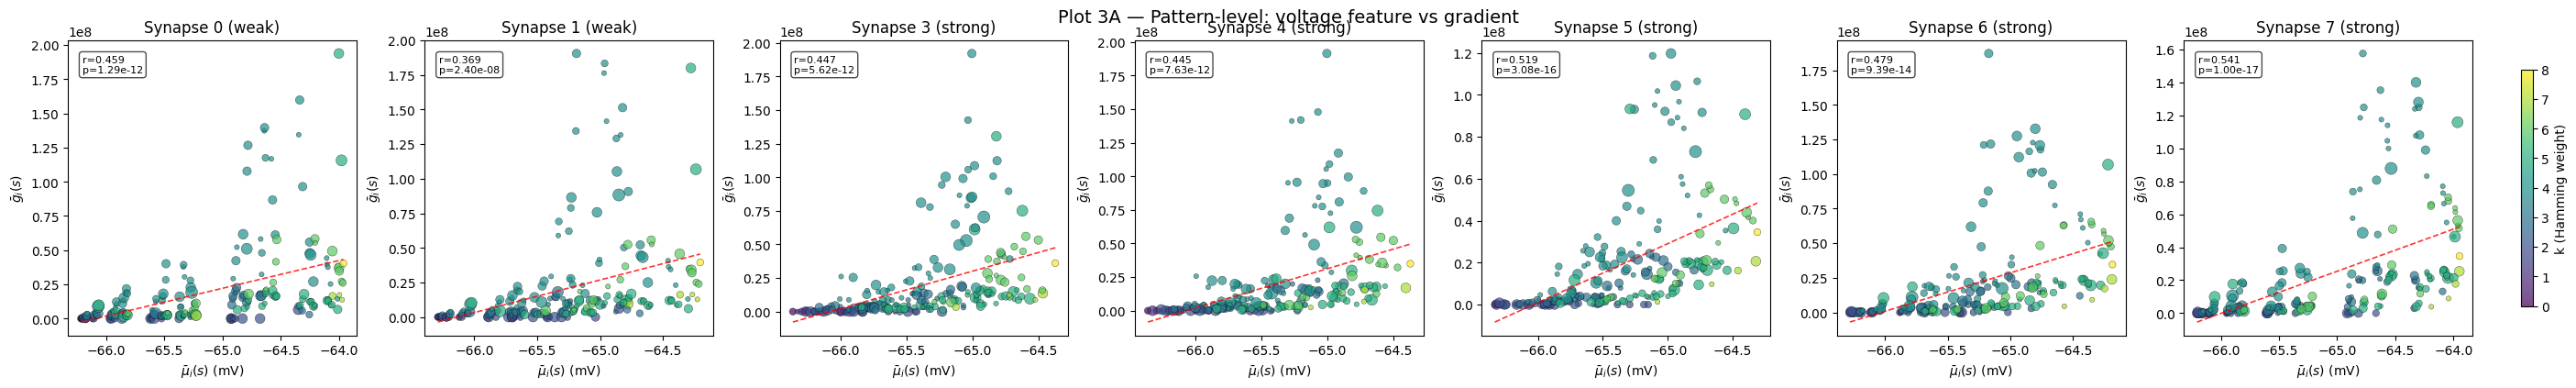

In [119]:
# ── Plot 3A: Scatter across patterns for chosen synapses ──
chosen_synapses = [0, 1, 3, 4, 5, 6, 7]  # weak: 0,1 ; strong: 3,4,5,6,7

n_chosen = len(chosen_synapses)
fig, axes = plt.subplots(1, n_chosen, figsize=(4 * n_chosen, 4),
                         constrained_layout=True)

pt = pattern_table  # shorthand

for ax_idx, syn_i in enumerate(chosen_synapses):
    ax = axes[ax_idx]
    mu_col = f"mu_bar_{syn_i}"
    g_col  = f"g_bar_{syn_i}"

    sc = ax.scatter(pt[mu_col], pt[g_col],
                    c=pt["k"], cmap="viridis",
                    s=pt["count"] * 15, alpha=0.7,
                    edgecolors="k", linewidths=0.3)

    # best-fit line
    slope, intercept, r_val, p_val, _ = stats.linregress(pt[mu_col], pt[g_col])
    x_fit = np.linspace(pt[mu_col].min(), pt[mu_col].max(), 100)
    ax.plot(x_fit, slope * x_fit + intercept, "r--", lw=1.2, alpha=0.8)
    ax.annotate(f"r={r_val:.3f}\np={p_val:.2e}",
                xy=(0.05, 0.95), xycoords="axes fraction",
                fontsize=8, va="top",
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

    ax.set_xlabel(r"$\bar\mu_i(s)$ (mV)")
    ax.set_ylabel(r"$\bar g_i(s)$")
    label = "weak" if syn_i in [0, 1] else "strong"
    ax.set_title(f"Synapse {syn_i} ({label})")

# shared colorbar
cbar = fig.colorbar(sc, ax=axes.tolist(), label="k (Hamming weight)",
                    shrink=0.8, pad=0.02)
fig.suptitle("Plot 3A — Pattern-level: voltage feature vs gradient",
             fontsize=14, y=1.02)
plt.show()


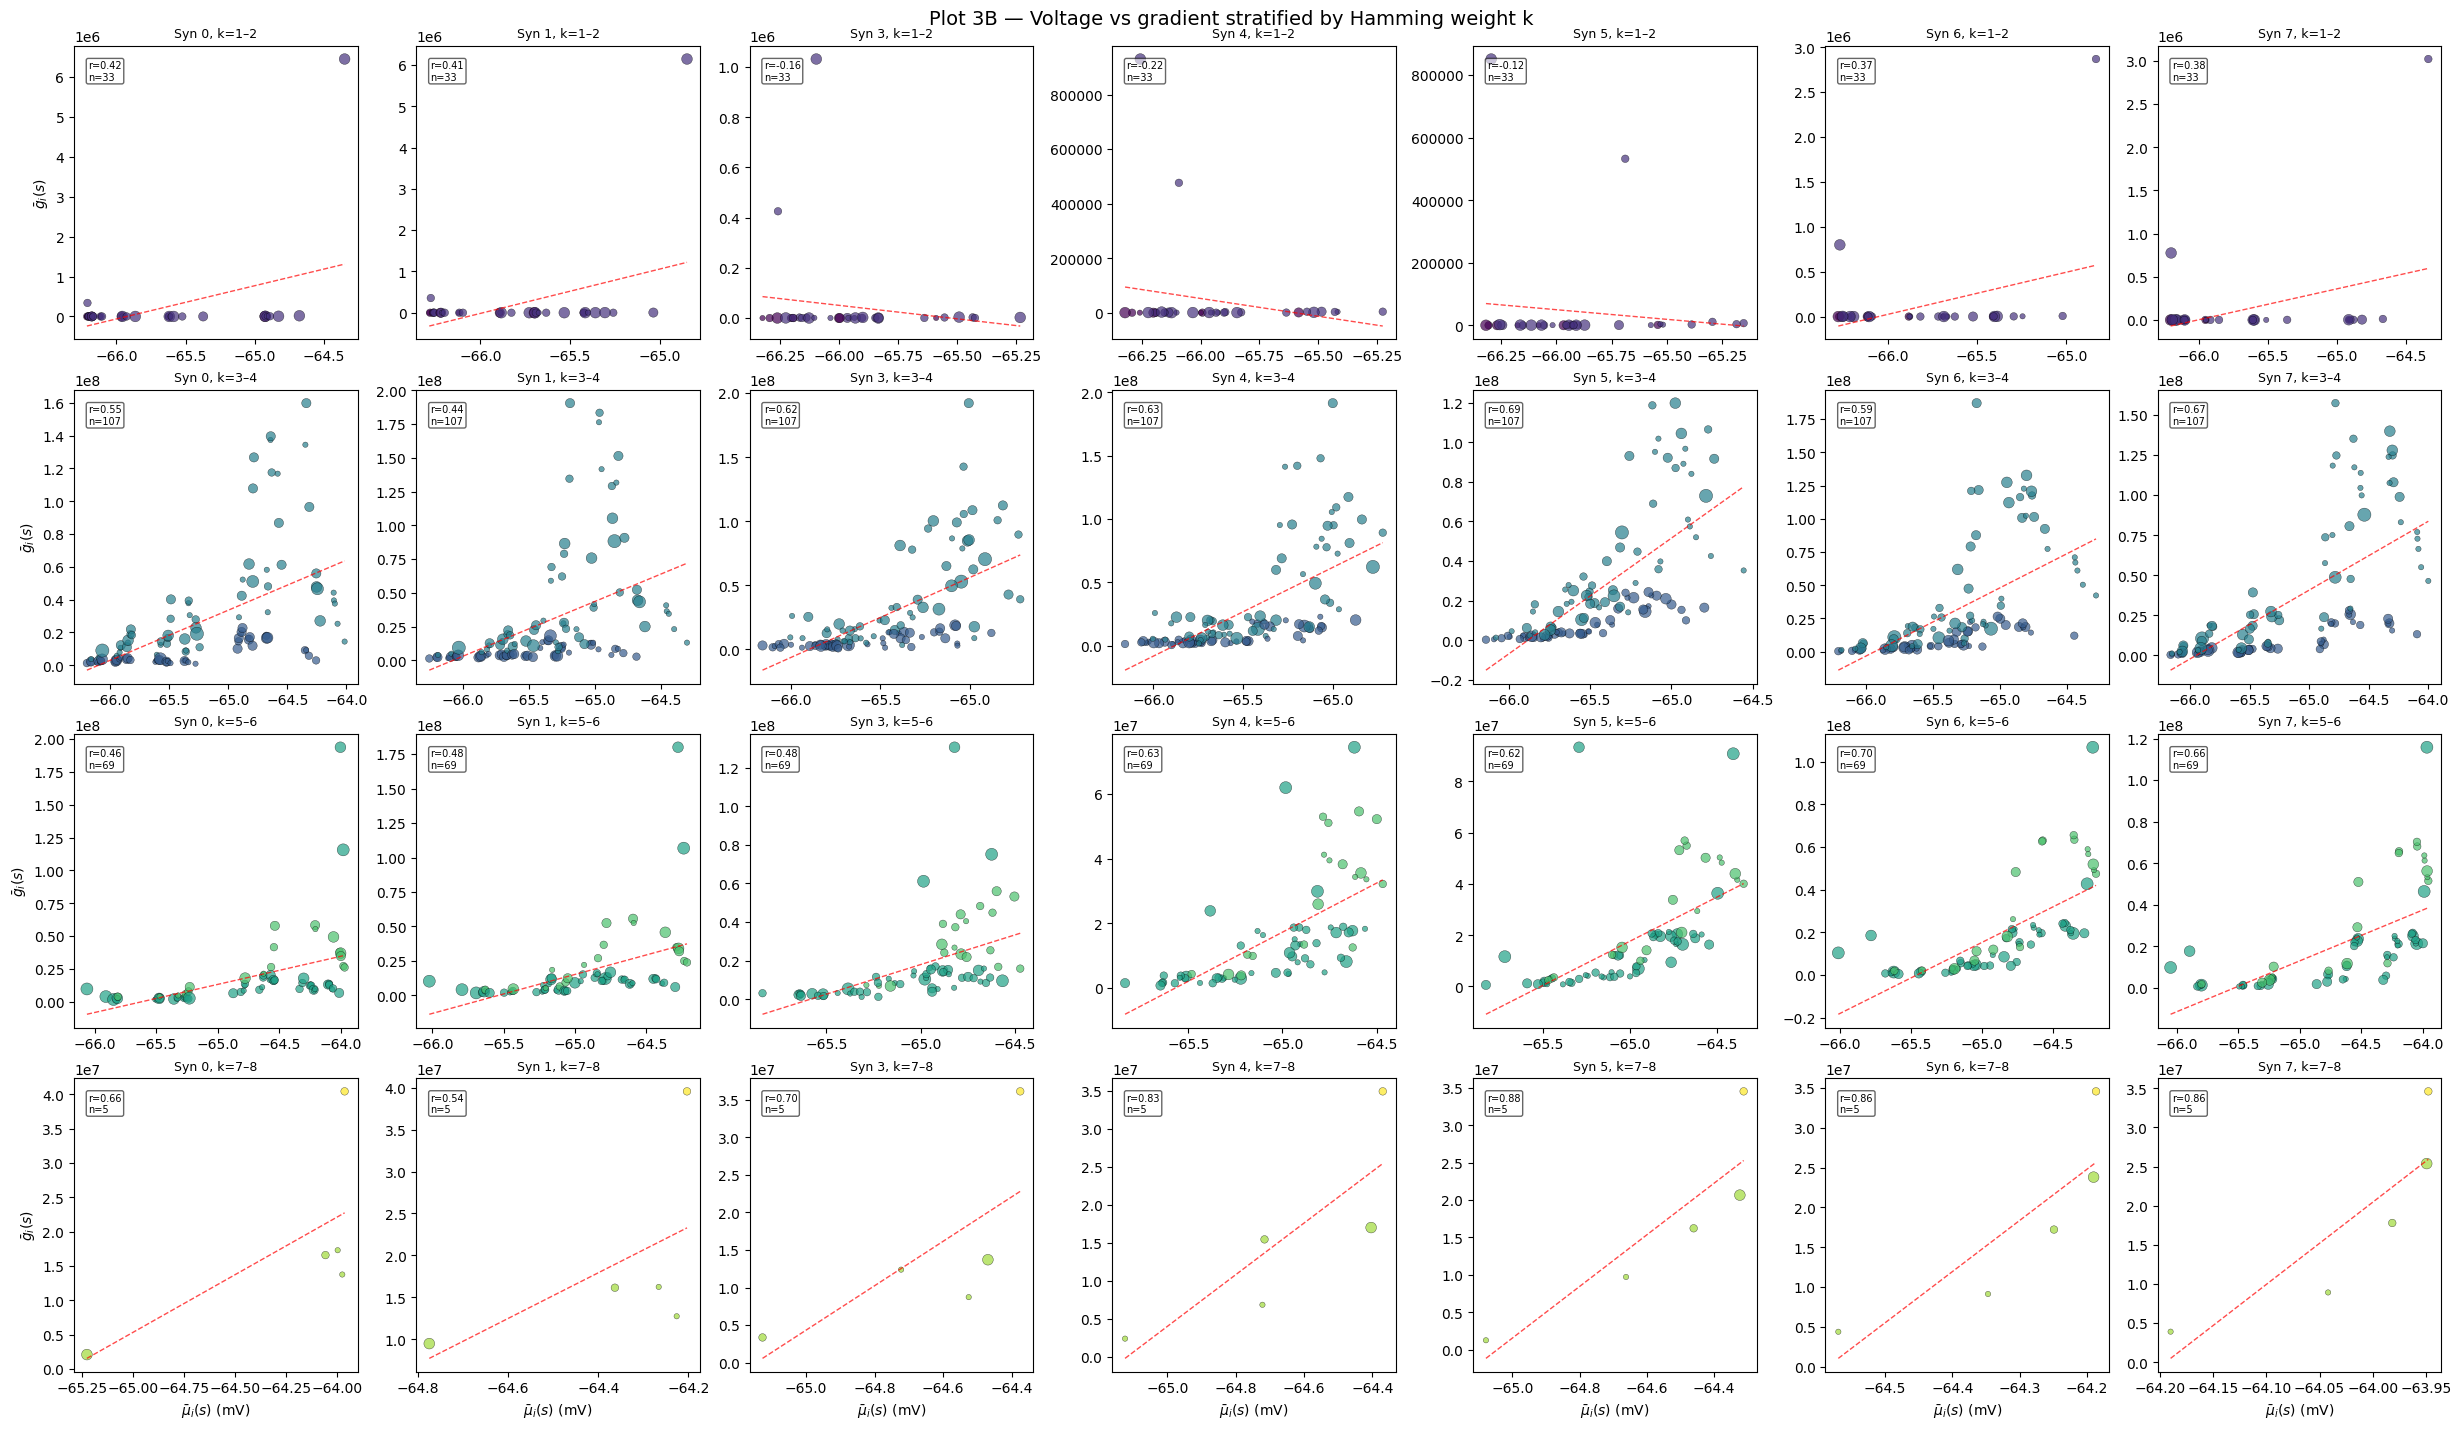

In [120]:
# ── Plot 3B: Stratified by k (Hamming weight) ──
k_bins = [(1, 2), (3, 4), (5, 6), (7, 8)]
k_bin_labels = ["k=1–2", "k=3–4", "k=5–6", "k=7–8"]

# One row per k-bin, one column per chosen synapse
n_kbins = len(k_bins)
fig, axes = plt.subplots(n_kbins, n_chosen, figsize=(3.5 * n_chosen, 3.5 * n_kbins),
                         constrained_layout=True)

for row, (k_lo, k_hi) in enumerate(k_bins):
    k_mask = (pt["k"] >= k_lo) & (pt["k"] <= k_hi)
    sub = pt[k_mask]

    for col, syn_i in enumerate(chosen_synapses):
        ax = axes[row, col]
        mu_col = f"mu_bar_{syn_i}"
        g_col  = f"g_bar_{syn_i}"

        if len(sub) < 3:
            ax.text(0.5, 0.5, f"n={len(sub)}", transform=ax.transAxes,
                    ha="center", fontsize=10)
            ax.set_title(f"Syn {syn_i}, {k_bin_labels[row]}")
            continue

        ax.scatter(sub[mu_col], sub[g_col],
                   c=sub["k"], cmap="viridis", vmin=1, vmax=8,
                   s=sub["count"] * 15, alpha=0.7,
                   edgecolors="k", linewidths=0.3)

        # regression if enough points
        if len(sub) >= 5:
            slope, intercept, r_val, p_val, _ = stats.linregress(
                sub[mu_col], sub[g_col])
            x_fit = np.linspace(sub[mu_col].min(), sub[mu_col].max(), 50)
            ax.plot(x_fit, slope * x_fit + intercept, "r--", lw=1, alpha=0.7)
            ax.annotate(f"r={r_val:.2f}\nn={len(sub)}",
                        xy=(0.05, 0.95), xycoords="axes fraction",
                        fontsize=7, va="top",
                        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6))

        ax.set_title(f"Syn {syn_i}, {k_bin_labels[row]}", fontsize=9)
        if col == 0:
            ax.set_ylabel(r"$\bar g_i(s)$")
        if row == n_kbins - 1:
            ax.set_xlabel(r"$\bar\mu_i(s)$ (mV)")

fig.suptitle("Plot 3B — Voltage vs gradient stratified by Hamming weight k",
             fontsize=14, y=1.01)
plt.show()


# Deliverable 4 — Pattern-level stats

**4A:** Weighted correlation (by count) between $\bar\mu_i(s)$ and $\bar g_i(s)$.

**4B:** Pattern-level linear model controlling for $k$:
$$\bar g_i(s) = a\cdot\bar\mu_i(s) + b\cdot k(s) + c$$

Does the voltage summary predict the gradient **beyond** "how many synapses are ON"?


In [121]:
from scipy.stats import pearsonr
import statsmodels.api as sm

# ── 4A: Weighted correlation ──
def weighted_corr(x, y, w):
    """Pearson-like correlation weighted by w."""
    w = np.asarray(w, dtype=float)
    w = w / w.sum()
    mx = np.average(x, weights=w)
    my = np.average(y, weights=w)
    dx = x - mx
    dy = y - my
    cov_xy = np.sum(w * dx * dy)
    std_x  = np.sqrt(np.sum(w * dx**2))
    std_y  = np.sqrt(np.sum(w * dy**2))
    r = cov_xy / (std_x * std_y + 1e-30)
    return r

print("=" * 80)
print("4A — Weighted correlation (weight = pattern count)")
print("=" * 80)
print(f"{'Synapse':>8}  {'r_weighted':>11}  {'r2_weighted':>12}  {'r_unweighted':>13}  {'p_unweighted':>13}")
print("-" * 80)

stats_4A = {}
for syn_i in chosen_synapses:
    mu_vals = pt[f"mu_bar_{syn_i}"].values
    g_vals  = pt[f"g_bar_{syn_i}"].values
    c_vals  = pt["count"].values

    r_w = weighted_corr(mu_vals, g_vals, c_vals)
    r_uw, p_uw = pearsonr(mu_vals, g_vals)

    stats_4A[syn_i] = {"r_weighted": r_w, "r2_weighted": r_w**2,
                       "r_unweighted": r_uw, "p_unweighted": p_uw}
    print(f"{syn_i:>8}  {r_w:>11.4f}  {r_w**2:>12.4f}  {r_uw:>13.4f}  {p_uw:>13.2e}")

# ── 4B: Pattern-level linear model controlling for k ──
print("\n" + "=" * 80)
print("4B — Linear model: g_bar_i = a * mu_bar_i + b * k + c")
print("=" * 80)
print(f"{'Synapse':>8}  {'a (coef_mu)':>12}  {'t-stat':>8}  {'p-value':>10}  "
      f"{'b (coef_k)':>11}  {'R² model':>9}")
print("-" * 80)

stats_4B = {}
for syn_i in chosen_synapses:
    mu_vals = pt[f"mu_bar_{syn_i}"].values
    g_vals  = pt[f"g_bar_{syn_i}"].values
    k_vals  = pt["k"].values.astype(float)

    X = sm.add_constant(np.column_stack([mu_vals, k_vals]))
    model = sm.WLS(g_vals, X, weights=pt["count"].values).fit()

    a_coef = model.params[1]
    a_tstat = model.tvalues[1]
    a_pval = model.pvalues[1]
    b_coef = model.params[2]
    r2_mod = model.rsquared

    stats_4B[syn_i] = {"a": a_coef, "t_stat": a_tstat, "p_value": a_pval,
                       "b": b_coef, "R2": r2_mod}
    print(f"{syn_i:>8}  {a_coef:>12.5f}  {a_tstat:>8.2f}  {a_pval:>10.2e}  "
          f"{b_coef:>11.5f}  {r2_mod:>9.4f}")

print("\nInterpretation: a > 0 and significant → voltage summary predicts gradient")
print("beyond just the number of active synapses (k).")


4A — Weighted correlation (weight = pattern count)
 Synapse   r_weighted   r2_weighted   r_unweighted   p_unweighted
--------------------------------------------------------------------------------
       0       0.4906        0.2407         0.4593       1.29e-12
       1       0.4268        0.1822         0.3692       2.40e-08
       3       0.4743        0.2249         0.4474       5.62e-12
       4       0.4697        0.2206         0.4448       7.63e-12
       5       0.5219        0.2723         0.5192       3.08e-16
       6       0.4712        0.2220         0.4794       9.39e-14
       7       0.5613        0.3151         0.5407       1.00e-17

4B — Linear model: g_bar_i = a * mu_bar_i + b * k + c
 Synapse   a (coef_mu)    t-stat     p-value   b (coef_k)   R² model
--------------------------------------------------------------------------------
       0  22631074.50246      6.98    3.68e-11  884252.03176     0.2417
       1  30403695.87788      5.78    2.66e-08  -1131722.83619 

# Deliverable 5 — "Fixed context" ON vs OFF contrast

For each synapse $i$, define context $c = s_{\neg i}$ (the 7-bit pattern excluding $i$).

For contexts appearing with **both** $s_i=0$ and $s_i=1$ (≥3 trials each):

$$\Delta\bar g_i(c) = E[g_i \mid s_i=1, c] - E[g_i \mid s_i=0, c]$$
$$\Delta\bar\mu_i(c) = E[\mu_i \mid s_i=1, c] - E[\mu_i \mid s_i=0, c]$$

Scatter: $\Delta\bar\mu_i$ vs $\Delta\bar g_i$ — a "controlled toggle" view.


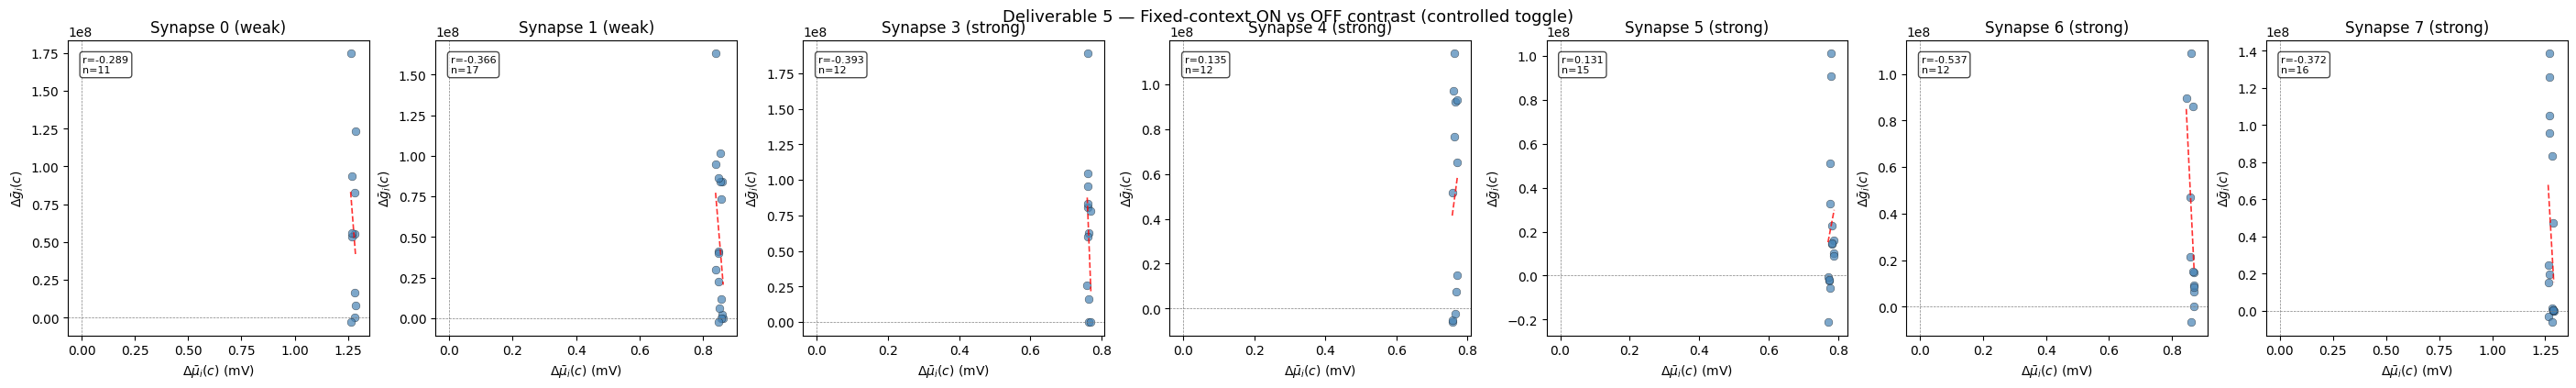


 Synapse   n_contexts    mean Δμ    mean Δg
--------------------------------------------------
       0           11     1.2747  60037251.57551
       1           17     0.8520  49330991.39741
       3           12     0.7635  66348120.02193
       4           12     0.7639  49910742.50965
       5           15     0.7794  22084812.64050
       6           12     0.8638  33355730.40427
       7           16     1.2774  40572406.50640


In [122]:
# ── Deliverable 5: Fixed-context ON vs OFF contrast ──
min_trials_ctx = 3

fig, axes = plt.subplots(1, n_chosen, figsize=(4 * n_chosen, 4),
                         constrained_layout=True)

d5_results = {}

for ax_idx, syn_i in enumerate(chosen_synapses):
    ax = axes[ax_idx]

    # Context = 7-bit pattern excluding synapse i
    ctx_cols = [j for j in range(Nsyn) if j != syn_i]
    contexts = patterns[:, ctx_cols]  # (N, 7)
    si = patterns[:, syn_i]           # (N,) — ON/OFF for synapse i

    # Convert each 7-bit context to an integer for grouping
    ctx_ints = np.array([int("".join(row.astype(int).astype(str)), 2)
                         for row in contexts])

    unique_ctx = np.unique(ctx_ints)

    delta_mu_list = []
    delta_g_list  = []

    for c in unique_ctx:
        c_mask = ctx_ints == c
        on_mask  = c_mask & (si == 1)
        off_mask = c_mask & (si == 0)

        if on_mask.sum() < min_trials_ctx or off_mask.sum() < min_trials_ctx:
            continue

        # Δμ and Δg
        delta_mu = MU_mean[on_mask, syn_i].mean() - MU_mean[off_mask, syn_i].mean()
        delta_g  = GRADS[on_mask, syn_i].mean()   - GRADS[off_mask, syn_i].mean()

        delta_mu_list.append(delta_mu)
        delta_g_list.append(delta_g)

    delta_mu_arr = np.array(delta_mu_list)
    delta_g_arr  = np.array(delta_g_list)
    n_ctx = len(delta_mu_arr)

    d5_results[syn_i] = {"delta_mu": delta_mu_arr, "delta_g": delta_g_arr,
                         "n_contexts": n_ctx}

    ax.scatter(delta_mu_arr, delta_g_arr, s=40, alpha=0.7,
               edgecolors="k", linewidths=0.3, color="steelblue")
    ax.axhline(0, color="grey", lw=0.5, ls="--")
    ax.axvline(0, color="grey", lw=0.5, ls="--")

    if n_ctx >= 5:
        slope, intercept, r_val, p_val, _ = stats.linregress(
            delta_mu_arr, delta_g_arr)
        x_fit = np.linspace(delta_mu_arr.min(), delta_mu_arr.max(), 50)
        ax.plot(x_fit, slope * x_fit + intercept, "r--", lw=1.2, alpha=0.8)
        ax.annotate(f"r={r_val:.3f}\nn={n_ctx}",
                    xy=(0.05, 0.95), xycoords="axes fraction",
                    fontsize=8, va="top",
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))
    else:
        ax.annotate(f"n={n_ctx}", xy=(0.05, 0.95), xycoords="axes fraction",
                    fontsize=8, va="top")

    ax.set_xlabel(r"$\Delta\bar\mu_i(c)$ (mV)")
    ax.set_ylabel(r"$\Delta\bar g_i(c)$")
    label = "weak" if syn_i in [0, 1] else "strong"
    ax.set_title(f"Synapse {syn_i} ({label})")

fig.suptitle("Deliverable 5 — Fixed-context ON vs OFF contrast (controlled toggle)",
             fontsize=13, y=1.02)
plt.show()

# Summary
print(f"\n{'Synapse':>8}  {'n_contexts':>11}  {'mean Δμ':>9}  {'mean Δg':>9}")
print("-" * 50)
for syn_i in chosen_synapses:
    d = d5_results[syn_i]
    if d["n_contexts"] > 0:
        print(f"{syn_i:>8}  {d['n_contexts']:>11}  "
              f"{d['delta_mu'].mean():>9.4f}  {d['delta_g'].mean():>9.5f}")
    else:
        print(f"{syn_i:>8}  {d['n_contexts']:>11}  {'—':>9}  {'—':>9}")
